In [49]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import numpy as np
import math
import networkx as nx
from tabulate import tabulate

# EDA on the sampled TwiBot-22 dataset

In [50]:
SAMPLED_DIR = "/Users/komalchandiramani/Desktop/NUS/s2/graphml/Group Project/data/static/"
os.makedirs("plots", exist_ok=True)

In [51]:
### load data
users_sampled_df = pd.read_csv(SAMPLED_DIR+"sampled_user_ids.csv")
tweets = pd.read_csv(SAMPLED_DIR+"sampled_tweet_ids.csv")
labels = pd.read_csv(SAMPLED_DIR+"bot_labels.csv")

In [52]:
### Build graph and obtain human bot interaction stats
G = nx.MultiDiGraph()
G.add_nodes_from(users_sampled_df["user_id"])

CHUNKSIZE = 20000
relation_counts = {}
bot_bot = Counter()
bot_human = Counter()
human_bot = Counter()
human_human = Counter()
num_edges = 0
labels_indexed = labels.set_index("id")[["label"]]

num_rows = sum(1 for _ in open(SAMPLED_DIR + "sampled_edges.csv")) - 1  # minus header
total_chunks = math.ceil(num_rows / CHUNKSIZE)

for chunk in tqdm(pd.read_csv(SAMPLED_DIR+"sampled_edges.csv", chunksize=CHUNKSIZE), total=total_chunks, desc="Processing edge chunks"):
    relations = dict(chunk['relation'].value_counts())
    relation_counts.update(relations)
    chunk = chunk.join(labels_indexed, on="source_id", how="left").rename(columns={"label": "source_label"})
    chunk = chunk.join(labels_indexed, on="target_id", how="left").rename(columns={"label": "target_label"})
    bb = dict(chunk[(chunk["source_label"] == "bot") & (chunk["target_label"] == "bot")]["relation"].value_counts())
    bot_bot.update(bb)
    bh = dict(chunk[(chunk["source_label"] == "bot") & (chunk["target_label"] == "human")]["relation"].value_counts())
    bot_human.update(bh)
    hb = dict(chunk[(chunk["source_label"] == "human") & (chunk["target_label"] == "bot")]["relation"].value_counts())
    human_bot.update(hb)
    hh = dict(chunk[(chunk["source_label"] == "human") & (chunk["target_label"] == "human")]["relation"].value_counts())
    human_human.update(hh)

    for s, r, t in zip(chunk["source_id"], chunk["relation"], chunk["target_id"]):
        if r not in ["followers", "following"]:
            continue
        G.add_edge(s, t, relation=r)

labels_dict = dict(zip(users_sampled_df["user_id"], users_sampled_df["label"]))
nx.set_node_attributes(G, labels_dict, "label")

Processing edge chunks: 100%|██████████| 538/538 [00:43<00:00, 12.23it/s]


In [53]:
### Graph stats
data = [
    ["# Nodes", G.number_of_nodes()],
    ["# Edges", G.number_of_edges()],
    ["# Relations", 2]
]
graph_summary = pd.DataFrame(data, columns=["Metric", "Value"])
latex_table = graph_summary.to_latex(index=True, escape=False)

print(graph_summary)

with open("./plots/graph_summary.tex", "w") as f:
    f.write(latex_table)
print("Saved to graph_summary.tex")

        Metric   Value
0      # Nodes   21359
1      # Edges  795397
2  # Relations       2
Saved to graph_summary.tex


In [54]:
### basic stats
num_users = users_sampled_df["user_id"].nunique()
num_humans = users_sampled_df[users_sampled_df["label"]=="human"]["user_id"].nunique()
num_bots = users_sampled_df[users_sampled_df["label"]=="bot"]["user_id"].nunique()
perc_humans = num_humans / num_users
perc_bots = num_bots / num_users
num_tweets = tweets["tweet_id"].nunique()
print(f"Num of users: {num_users}")
print(f"Num of bot users: {num_bots}")
print(f"No of human users: {num_humans}")
print(f"Percentage of human users: {perc_humans * 100:.2f}%")
print(f"Percentage of bot users: {perc_bots * 100:.2f}%")

print(f"Num of tweets: {num_tweets}")

Num of users: 21359
Num of bot users: 2776
No of human users: 18583
Percentage of human users: 87.00%
Percentage of bot users: 13.00%
Num of tweets: 8369615


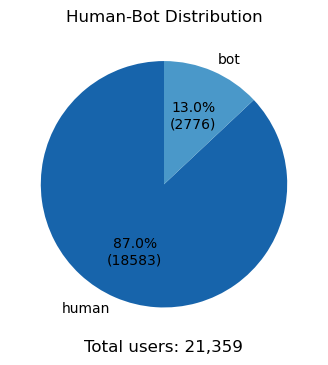

In [55]:
label_counts = users_sampled_df["label"].value_counts()
cmap = plt.colormaps["Blues"]
colors = [cmap(0.8), cmap(0.6)]

def autopct_format(values):
    def my_format(p):
        total = sum(values)
        count = int(round(p * total / 100.0))
        return f"{p:.1f}%\n({count})"
    return my_format

plt.figure(figsize=(6, 4))
plt.pie(label_counts, labels = label_counts.index, autopct=autopct_format(label_counts.values), startangle=90, colors=colors)
plt.title("Human-Bot Distribution")
plt.text(0.5, -0.03, f"Total users: {label_counts.sum():,}", ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
plt.savefig("./plots/human_bot_distbn_sampled.png")
plt.show()

In [56]:
### Average degree
human_degree = users_sampled_df[users_sampled_df["label"] == "human"]["degree"]
bot_degree = users_sampled_df[users_sampled_df["label"] == "bot"]["degree"]

human_followers = users_sampled_df[users_sampled_df["label"] == "human"]["followers_count"]
bot_followers = users_sampled_df[users_sampled_df["label"] == "bot"]["followers_count"]

human_following = users_sampled_df[users_sampled_df["label"] == "human"]["following_count"]
bot_following = users_sampled_df[users_sampled_df["label"] == "bot"]["following_count"]

human_degree_avg = human_degree.mean()
bot_degree_avg = bot_degree.mean()
human_followers_avg = human_followers.mean()
bot_followers_avg = bot_followers.mean()
human_following_avg = human_following.mean()
bot_following_avg = bot_following.mean()
pd.DataFrame([[human_degree_avg, bot_degree_avg], [human_followers_avg, bot_followers_avg], [human_following_avg, bot_following_avg]], columns=["Human", "Bot"], index=["Avg Degree", "Avg followers", "Avg following"])

,Human,Bot
Avg Degree,202.066943,125.061960
Avg followers,713580.831351,19135.187320
Avg following,7306.125007,3675.974063


# Bot-Human Interaction

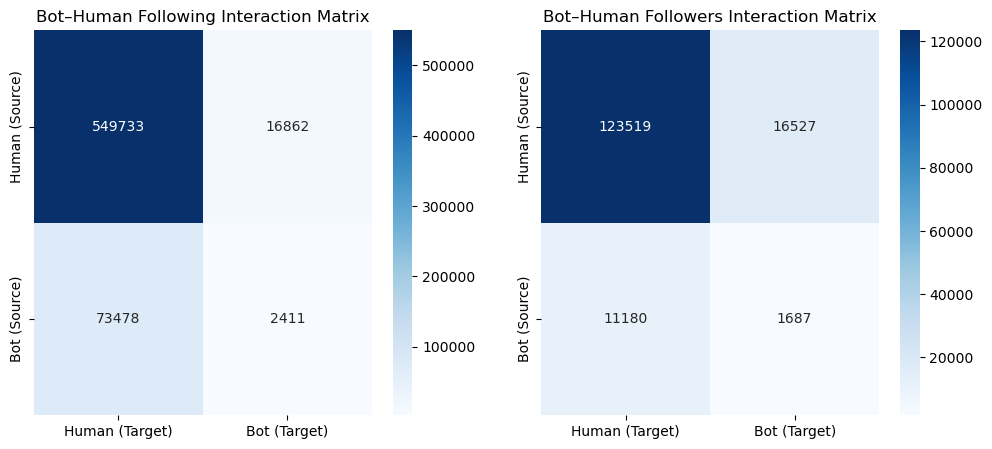

In [57]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
mat = pd.DataFrame(
    [[human_human["following"], human_bot["following"]],
     [bot_human["following"], bot_bot["following"]]],
    index=["Human (Source)", "Bot (Source)"],
    columns=["Human (Target)", "Bot (Target)"]
)

sns.heatmap(mat, annot=True, fmt=".0f", cmap="Blues")
plt.title("Bot–Human Following Interaction Matrix")

plt.subplot(1, 2, 2)
mat2 = pd.DataFrame(
    [[human_human["followers"], human_bot["followers"]],
     [bot_human["followers"], bot_bot["followers"]]],
    index=["Human (Source)", "Bot (Source)"],
    columns=["Human (Target)", "Bot (Target)"]
)

sns.heatmap(mat2, annot=True, fmt=".0f", cmap="Blues")
plt.title("Bot–Human Followers Interaction Matrix")
plt.savefig("./plots/bot_human_interaction.png")
plt.show()



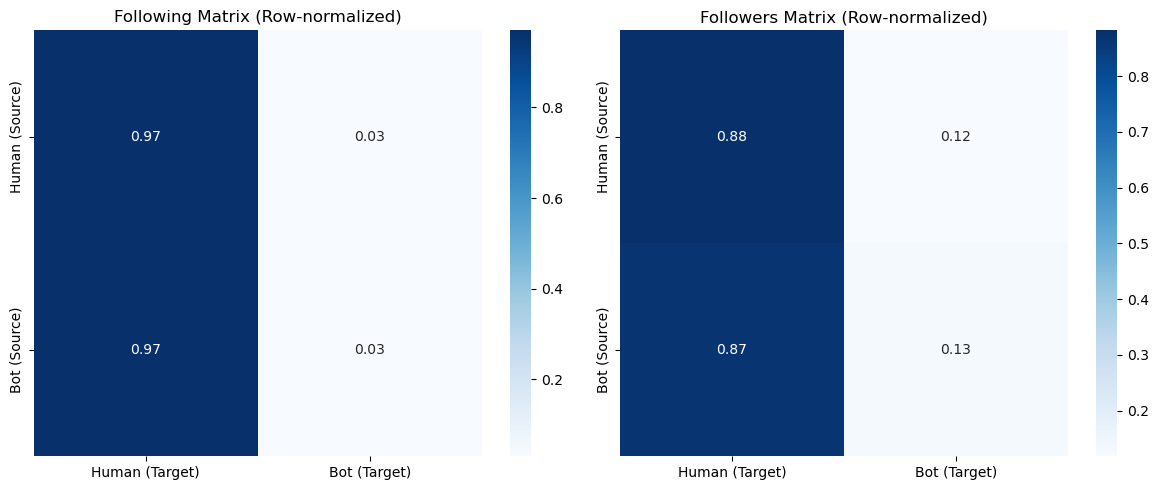

In [58]:
plt.figure(figsize=(12,5))

# Row-normalized Following
plt.subplot(1, 2, 1)
mat_norm = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Following Matrix (Row-normalized)")

# Row-normalized Followers
plt.subplot(1, 2, 2)
mat2_norm = mat2.div(mat2.sum(axis=1), axis=0)
sns.heatmap(mat2_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Followers Matrix (Row-normalized)")

plt.tight_layout()
plt.savefig("./plots/bot_human_interaction_normalized.png")
plt.show()


Bots follow humans in almost all cases (around 97%), which shows that bot accounts tend to direct their activity toward real users rather than other bots. In contrast, humans follow bots only about 3% of the time. This imbalance is consistent with the overall composition of the dataset, where humans make up the large majority of accounts (87% human vs. 13% bot). This suggests that bots overwhelmingly initiate interactions with humans, whereas humans interact with bots far less frequently.

# Comparison of centrality measures between Humans and Bots

### PageRank

In [59]:
#### PAGERANK
pr = nx.pagerank(G, alpha=0.85)
pr_sorted = dict(sorted(pr.items(), key=lambda x : x[1], reverse=True))
pr_sorted_rank = {node_id: i+1 for i, node_id in enumerate(pr_sorted.keys())}
pagerank = pd.DataFrame(list(pr_sorted_rank.items()), columns=["user_id", "rank"])
pagerank["pagerank_value"] = pr_sorted.values()
pagerank_df = pagerank.merge(users_sampled_df[["user_id", "label"]] ,on="user_id", how="left")

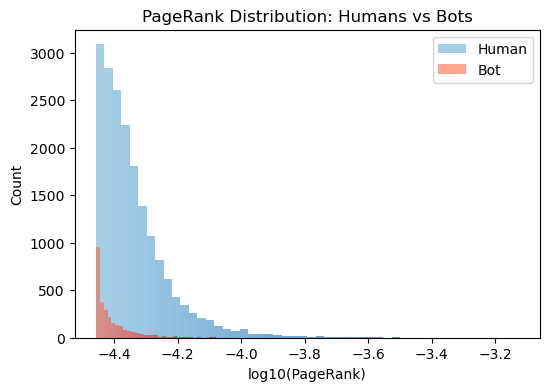

In [60]:
plt.figure(figsize=(6, 4))
counts, bins, patches = plt.hist(np.log10(pagerank_df[pagerank_df.label=="human"]["pagerank_value"] + 1e-12), 
         bins=50, alpha=0.6, label="Human")

counts2, bins2, patches2 = plt.hist(np.log10(pagerank_df[pagerank_df.label=="bot"]["pagerank_value"] + 1e-12),
         bins=50, alpha=0.6, label="Bot")

cmap_h = plt.colormaps["Blues"]
for i, p in enumerate(patches):
    p.set_facecolor(cmap_h(0.5 + 0.6 * (i / len(patches))))

cmap_b = plt.colormaps["Reds"]
for i, p in enumerate(patches2):
    p.set_facecolor(cmap_b(0.5 + 0.6 * (i / len(patches2))))

plt.legend()
plt.xlabel("log10(PageRank)")
plt.ylabel("Count")
plt.title("PageRank Distribution: Humans vs Bots")
plt.savefig("./plots/pagerank.png")
plt.show()


The PageRank distributions for both humans and bots are concentrated near low values, meaning most accounts — regardless of type — have limited structural influence in the network. While humans exhibit a longer right tail with a few higher-ranked nodes, the overall shape of the distribution is broadly similar, with both groups dominated by low-PageRank accounts.

### Degree Centrality

In [61]:
### Degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_df = pd.DataFrame(list({i: val for i, val in degree_centrality.items()}.items()), columns=["user_id", "dc"])
degree_centrality_df = degree_centrality_df.merge(users_sampled_df[["user_id", "label"]] ,on="user_id", how="left")

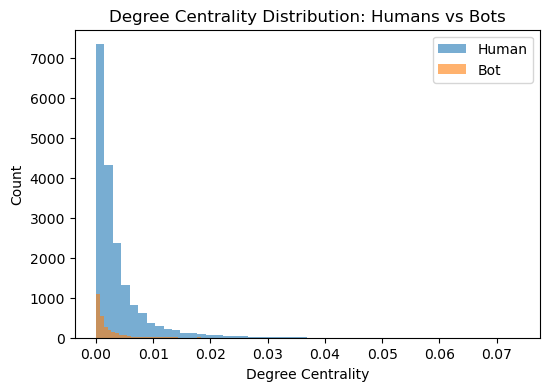

In [62]:
plt.figure(figsize=(6,4))

plt.hist(degree_centrality_df[degree_centrality_df.label=="human"]["dc"], bins=50, alpha=0.6, label="Human")
plt.hist(degree_centrality_df[degree_centrality_df.label=="bot"]["dc"], bins=50, alpha=0.6, label="Bot")

plt.xlabel("Degree Centrality")
plt.ylabel("Count")
plt.title("Degree Centrality Distribution: Humans vs Bots")
plt.legend()
plt.savefig("./plots/degree_centrality.png")
plt.show()


Similar to the PageRank results, both humans and bots are heavily concentrated near very low degree‐centrality values, meaning most accounts have relatively few direct connections. As degree centrality increases, the number of accounts drops sharply for both groups. However, humans show a noticeably longer right tail, indicating that high‐connectivity nodes are far more common among human accounts than bot accounts.

# Community Detection

In [63]:
comms = nx.community.louvain_communities(G, seed=42)
sorted_comms = sorted(comms, key=lambda s: len(s), reverse=True)

com_len = [len(c) for c in sorted_comms]
avg_com_len = sum(com_len) / len(com_len)
print(f"Number of communities detected: {len(comms)}")

Number of communities detected: 627


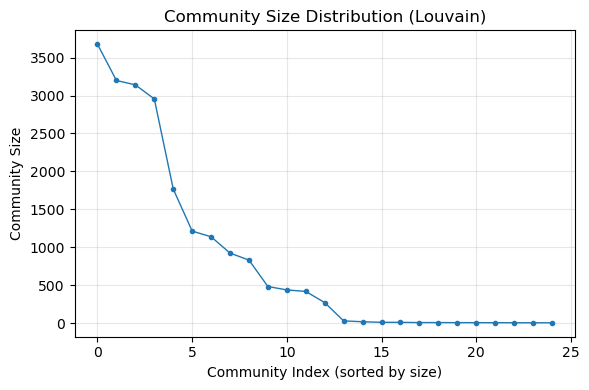

In [64]:
k = 25
plt.figure(figsize=(6, 4))
plt.plot(range(k), com_len[:k], marker='o', markersize=3, linewidth=1)

plt.title("Community Size Distribution (Louvain)")
plt.xlabel("Community Index (sorted by size)")
plt.ylabel("Community Size")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("./plots/community_size.png")
plt.show()

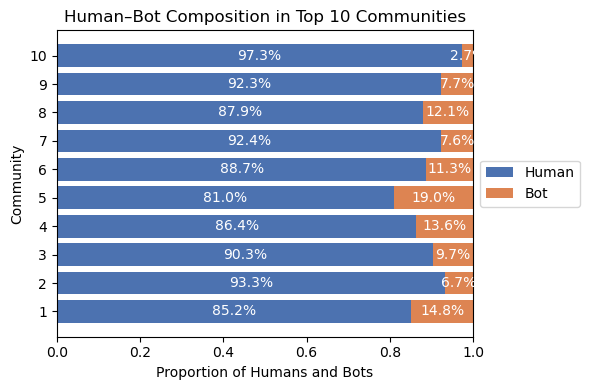

In [70]:
top_k = 10
top_comms = sorted_comms[:top_k]

rows = []
for idx, com in enumerate(top_comms, 1):
    labels = users_sampled_df[users_sampled_df.user_id.isin(com)]["label"]
    humans = (labels == "human").sum()
    bots = (labels == "bot").sum()
    total = humans + bots
    rows.append([idx, humans/total, bots/total])

df_norm = pd.DataFrame(rows, columns=["community", "human_pct", "bot_pct"])

fig, ax = plt.subplots(figsize=(6, 4))

# Horizontal stacked bars
ax.barh(df_norm["community"], df_norm["human_pct"], label="Human", color="#4C72B0")
ax.barh(df_norm["community"], df_norm["bot_pct"], 
        left=df_norm["human_pct"], label="Bot", color="#DD8452")

# Add percentage labels
for i, (h, b) in enumerate(zip(df_norm["human_pct"], df_norm["bot_pct"])):
    ax.text(h / 2, df_norm["community"][i], f"{h*100:.1f}%",
            ha="center", va="center", color="white", fontsize=10)
    ax.text(h + b / 2, df_norm["community"][i], f"{b*100:.1f}%",
            ha="center", va="center", color="white", fontsize=10)

# Axis formatting
ax.set_xlabel("Proportion of Humans and Bots")
ax.set_xlim(0, 1)
ax.set_ylabel("Community")
ax.set_yticks(df_norm["community"])
ax.set_title("Human–Bot Composition in Top 10 Communities")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("./plots/hb_top10_communities.png")
plt.show()



In [66]:
G_undirected = G.to_undirected()
components = list(nx.connected_components(G_undirected))

# Largest connected component
largest_component_nodes = max(components, key=len)
largest_component_nodes = set(largest_component_nodes)

print("Size of Largest Connected Component:", len(largest_component_nodes))


Size of Largest Connected Component: 20805


In [67]:
subset = users_sampled_df[users_sampled_df["label"] == "human"]
pct = subset["user_id"].isin(largest_component_nodes).mean() * 100
print("% Human accounts in Largest Connected Components:", pct)

subset = users_sampled_df[users_sampled_df["label"] == "bot"]
pct = subset["user_id"].isin(largest_component_nodes).mean() * 100
print("% Bot accounts in Largest Connected Component:", pct)


% Human accounts in Largest Connected Components: 98.8053597373944
% Bot accounts in Largest Connected Component: 88.04034582132564


Almost all human accounts (≈99%) belong to the largest connected component, showing that humans are tightly interconnected across the network. In contrast, only about 88% of bot accounts fall inside this main component, suggesting that bots tend to be less embedded and more structurally isolated compared to humans.

# Summary table

In [68]:
summary_rows = []

for label in ["human", "bot"]:
    subset = users_sampled_df[users_sampled_df["label"] == label]

    row = {
        "Label": label.capitalize(),
        "Num Accounts": len(subset),
        # "Avg Followers": subset["followers_count"].mean(),
        "Median Followers": subset["followers_count"].median(),
        # "Avg Following": subset["following_count"].mean(),
        "Median Following": subset["following_count"].median(),
        # "Avg PageRank (log10)": np.log10(pagerank_df[pagerank_df["label"] == label]["pagerank_value"]).mean(),
        "Median PageRank (log10)": np.log10(pagerank_df[pagerank_df["label"] == label]["pagerank_value"]).median(),
        # "Avg Degree Centrality": degree_centrality_df[degree_centrality_df["label"] == label]["dc"].mean(),
        "Median Degree Centrality": degree_centrality_df[degree_centrality_df["label"] == label]["dc"].median(),
        "% in Largest Connected Component": (
            subset["user_id"].isin(largest_component_nodes).mean() * 100
            if 'largest_component_nodes' in globals() else np.nan
        )
    }
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index("Label").T
summary_df.loc["Num Accounts"] = summary_df.loc["Num Accounts"].astype(int)
float_rows = summary_df.index.difference(["Num Accounts"])
summary_df.loc[float_rows] = summary_df.loc[float_rows].astype(float).round(4)

print(tabulate(summary_df, headers="keys", numalign="left", tablefmt='psql'))

# Generate LaTeX
latex_summary = summary_df.to_latex(index=True, float_format="%.4f", escape=False)
with open("./plots/summary_stats.tex", "w") as f:
    f.write(latex_summary)


+----------------------------------+---------+---------+
|                                  | Human   | Bot     |
|----------------------------------+---------+---------|
| Num Accounts                     | 18583   | 2776    |
| Median Followers                 | 8158    | 186     |
| Median Following                 | 1031    | 335     |
| Median PageRank (log10)          | -4.3698 | -4.4311 |
| Median Degree Centrality         | 0.0021  | 0.001   |
| % in Largest Connected Component | 98.8054 | 88.0403 |
+----------------------------------+---------+---------+
